#importing essential libraries 

In [130]:
import pandas as pd               
import matplotlib.pyplot as plt   
import seaborn as sns 
import numpy as np   
import warnings
warnings.filterwarnings('ignore')

#loading the data set 

In [133]:
# load the data set
df=pd.read_csv('Walmart_Sales.csv')

In [135]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


# data preprocessing 

In [140]:
df.shape

(6435, 8)

In [142]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [144]:
df.duplicated().sum()

0

In [146]:
# handling  ouliers
num_columns=df.select_dtypes(include=np.number).columns
indices_to_remove = ['Holiday_Flag'] # Creating the varible with holiday flag column
num_columns=num_columns.difference(indices_to_remove)
num_columns

Index(['CPI', 'Fuel_Price', 'Store', 'Temperature', 'Unemployment',
       'Weekly_Sales'],
      dtype='object')

In [148]:
def remove_outliers(df1,col):
    q1=df1[col].quantile(0.25)
    q3=df1[col].quantile(0.75) 
    IQR=q3-q1  
    Lower_Band = q1-1.5*IQR 
    Upper_Band = q3+1.5*IQR 
    df[col]=np.clip(df[col],Lower_Band,Upper_Band)
    return df1

# Defining the function that can remove outliers
def treat_outliers(df1,col_list):
    for col in col_list:              
        df1=remove_outliers(df1,col) 
    return df1 

In [150]:
df=treat_outliers(df,num_columns) 

#Exploretary data analysis 

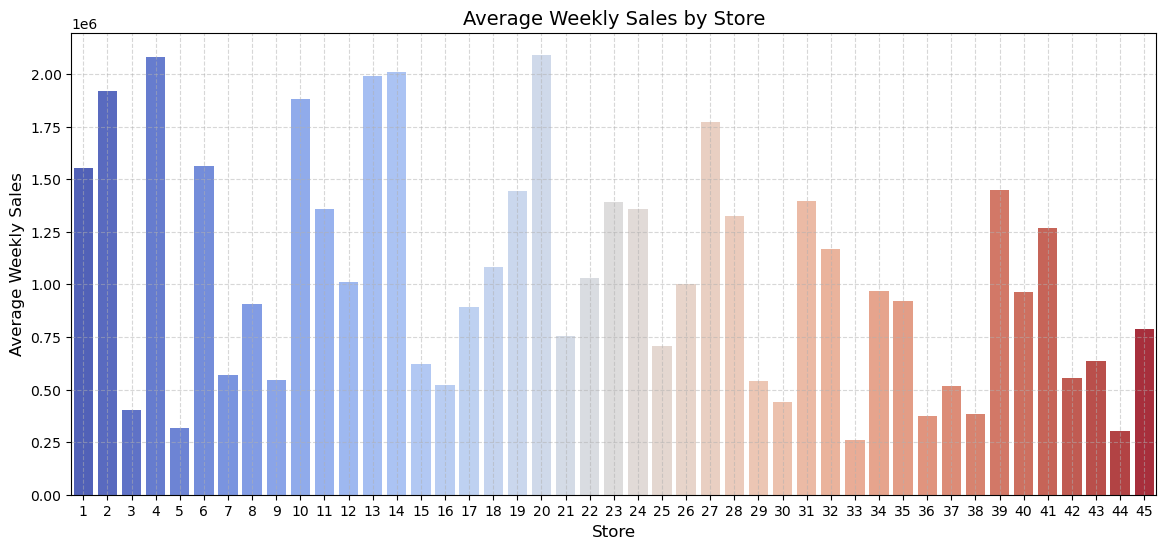

In [153]:
store_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=store_sales.index, y=store_sales.values, palette='coolwarm')
plt.title('Average Weekly Sales by Store', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


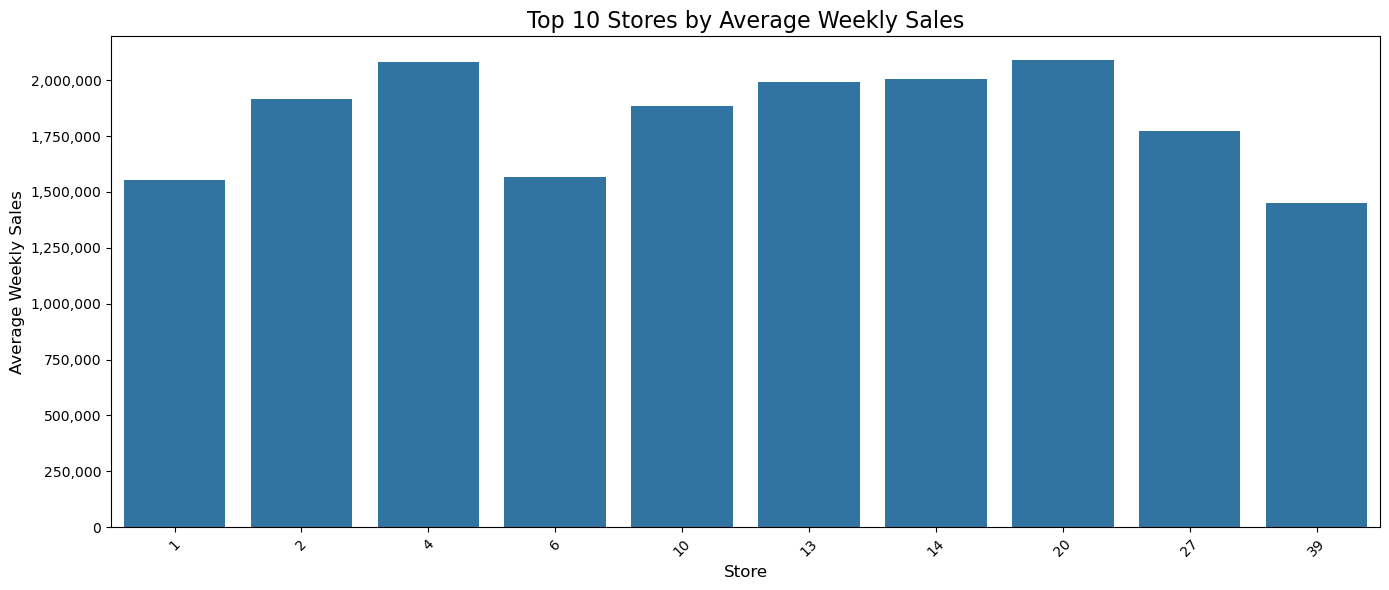

In [155]:
store_sales = df.groupby('Store')['Weekly_Sales'].mean()

# get top 10 stores 
top_10_stores = store_sales.sort_values(ascending=False).head(10)
top10_df = top_10_stores.reset_index().rename(columns={'Weekly_Sales': 'Avg_Weekly_Sales'})# convert to data frame 
def thousands_formatter(x, pos):
    return '{:,.0f}'.format(x)
plt.figure(figsize=(14,6))
sns.barplot(x='Store', y='Avg_Weekly_Sales', data=top10_df)
plt.title('Top 10 Stores by Average Weekly Sales', fontsize=16)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Sales')

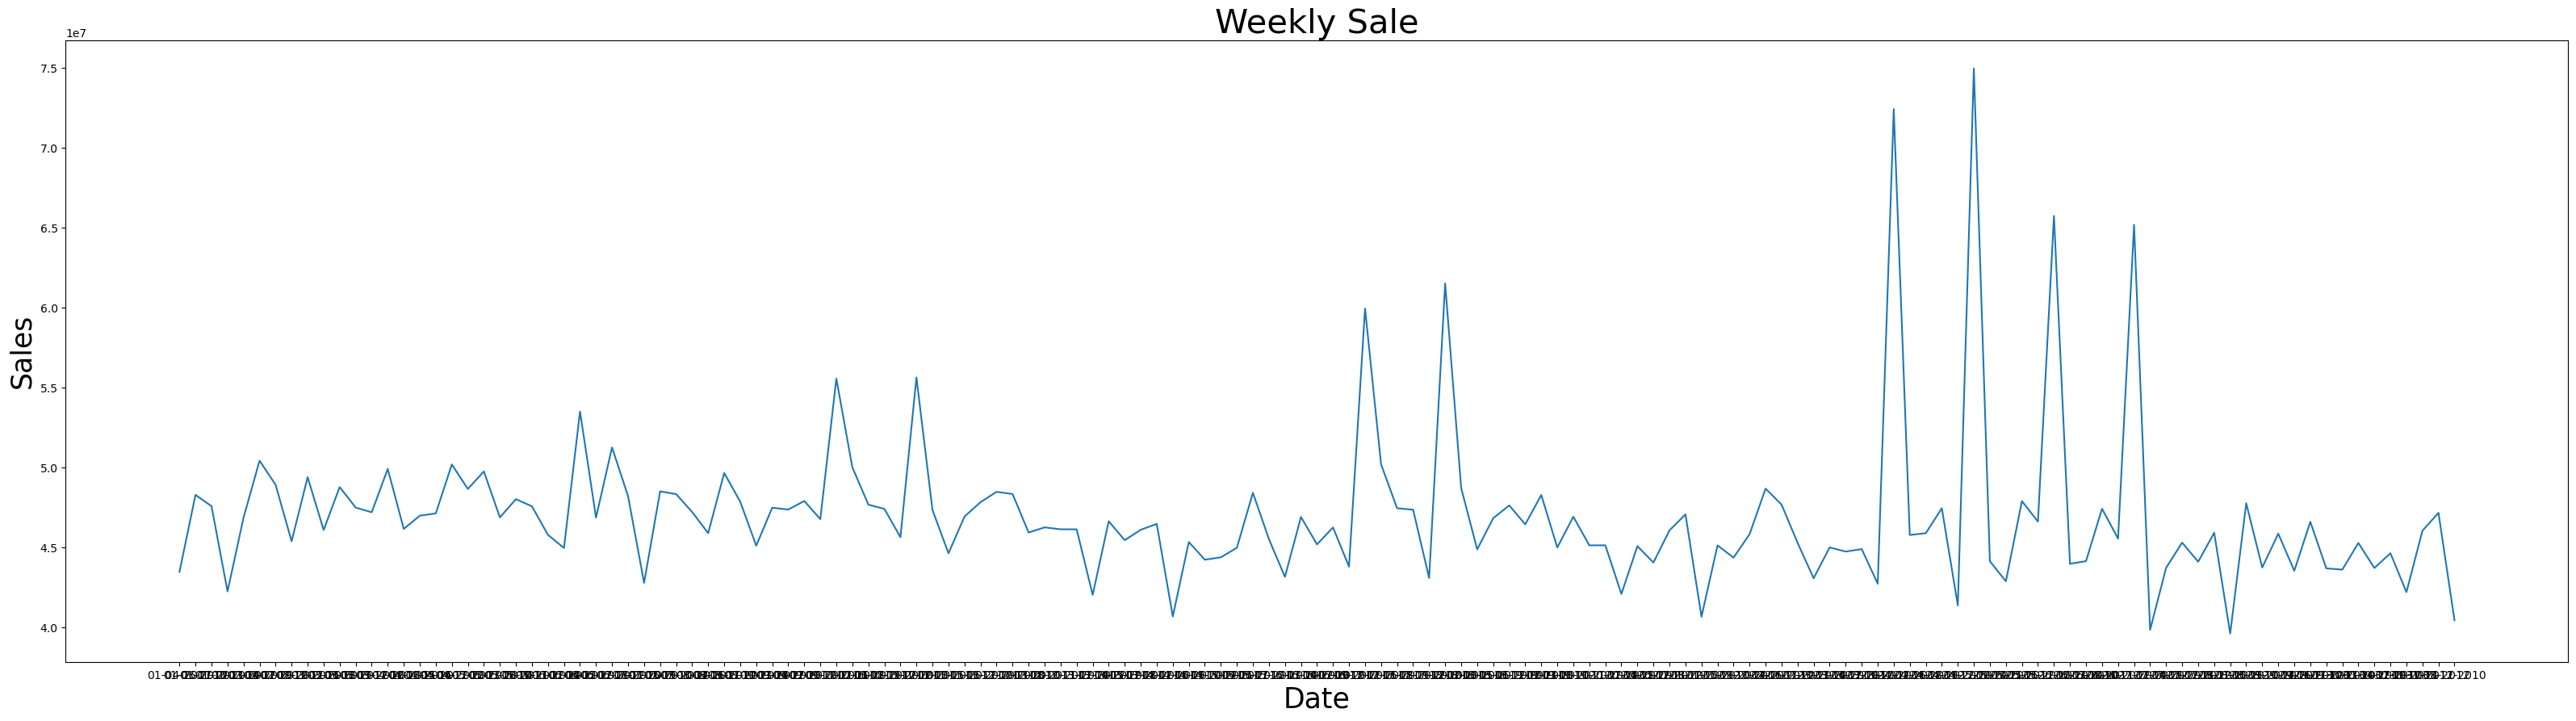

In [157]:
#  trend of weekly sales
df_date_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_date_sales=df_date_sales.sort_values(by='Date',ascending=True)
plt.figure(figsize=(40,10)) 
sns.lineplot(x='Date',y='Weekly_Sales',data=df_date_sales) 
plt.title('Weekly Sale',fontsize=30) 
plt.xlabel('Date',fontsize=25) 
plt.ylabel('Sales',fontsize=25) 

# forcasting sales  by using ARIMA model


In [160]:
df_stores_sales =df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_stores_sales.set_index('Date',inplace=True)

In [162]:
from statsmodels.tsa.stattools import adfuller # importing the adfuller for check the data stationarity

# check for stationarity
def adf_test(series, title=''): # creating a function

    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series,autolag='AIC')
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:

        print("Rejects the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary.")

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(df_stores_sales['Weekly_Sales'],period=13)


In [166]:
mean1=df_stores_sales.rolling(window=10).mean()
std1=df_stores_sales.rolling(window=10).std() 

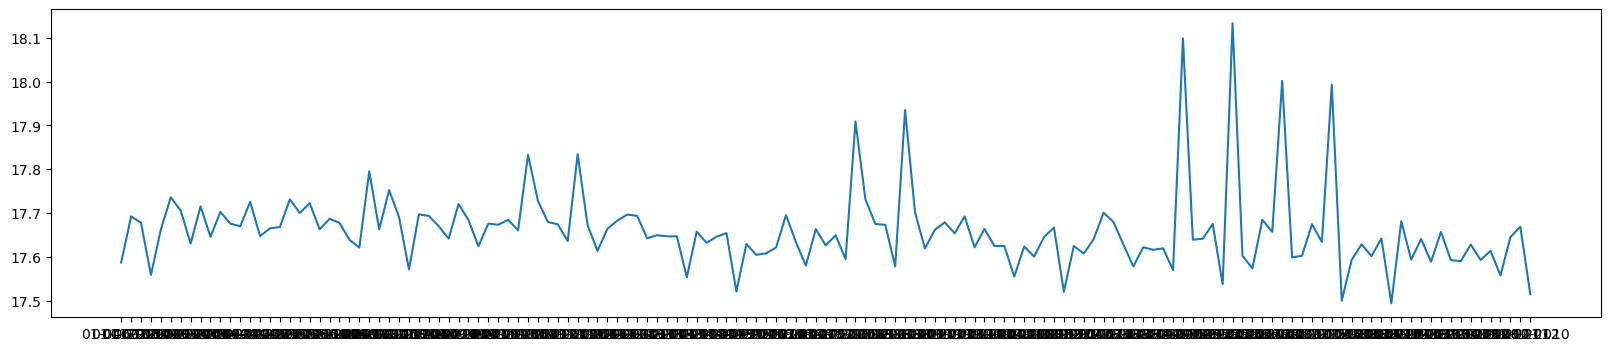

In [168]:
df_log = np.log(df_stores_sales)
plt.figure(figsize=(20,4))
plt.plot(df_log)

In [170]:
mean_log = df_log.rolling(window = 10).mean()
std_log = df_log.rolling(window = 10).std()          

In [172]:
df_new = df_log - mean_log
df_new.head(10)         

,Weekly_Sales
Date,
01-04-2011,NaN
01-06-2012,NaN
01-07-2011,NaN
01-10-2010,NaN
02-03-2012,NaN
02-04-2010,NaN
02-07-2010,NaN
02-09-2011,NaN
02-12-2011,NaN


In [174]:
 mean2 = df_new.rolling(window = 12).mean()
std2 = df_new.rolling(window = 12).std() 

In [176]:
# Buliding the ARIMA MODEL
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(df_new, order=(5, 1, 3))
arima_result = model.fit()

# Get predictions on historical data
predictions = arima_result.predict()

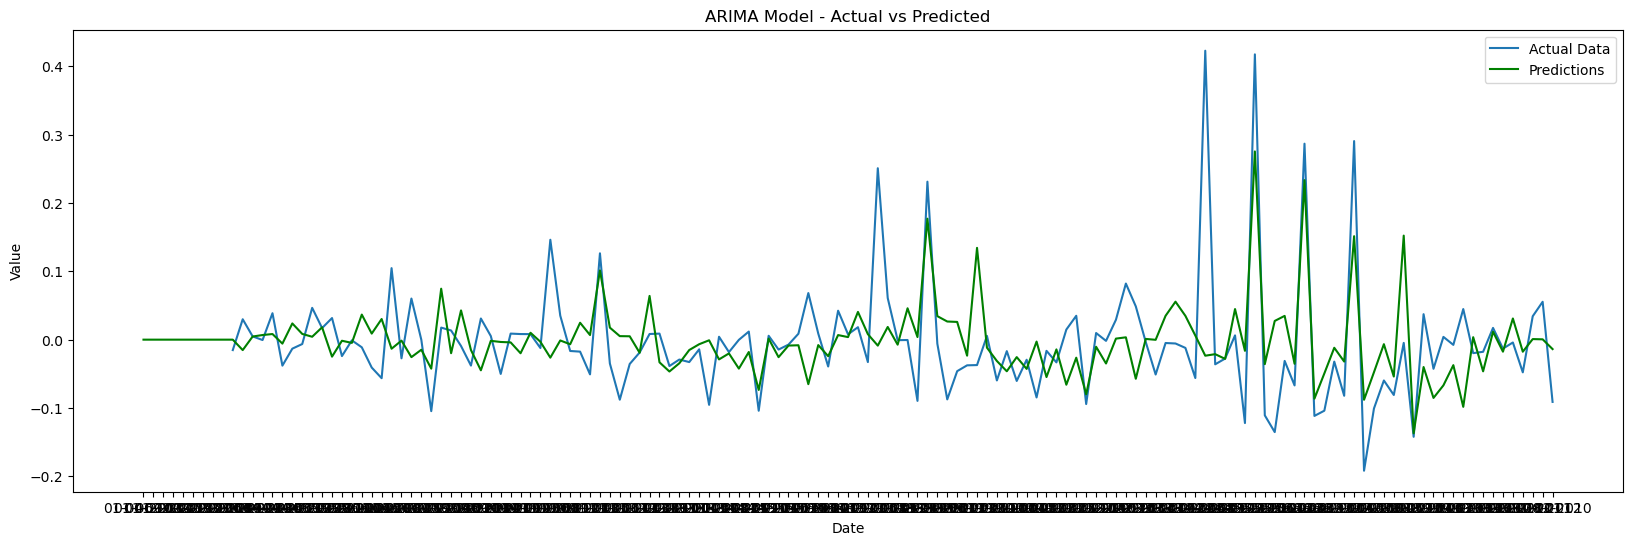

In [178]:
#ploating  ARIMA model prediction with respect to the actual  value
plt.figure(figsize=(20,6))
plt.plot(df_new, label='Actual Data')
plt.plot(predictions, color='green', label='Predictions')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [179]:
df_log = np.log(df_stores_sales)
df_new = df_log - mean_log


In [182]:
#metrics  to measure  performance of ARIMA  model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
y_true = df_new.squeeze()           
y_pred = predictions[:len(y_true)]  
valid_idx = (~np.isnan(y_true)) & (~np.isnan(y_pred))
y_true = y_true[valid_idx]
y_pred = y_pred[valid_idx]

# Compute metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.0055
Mean Absolute Error (MAE): 0.0499
Root Mean Squared Error (RMSE): 0.0740


In [184]:
import pickle

# Save  trained ARIMA model
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_result, f)

print("✅ ARIMA model saved successfully as 'arima_model.pkl'")


✅ ARIMA model saved successfully as 'arima_model.pkl'
